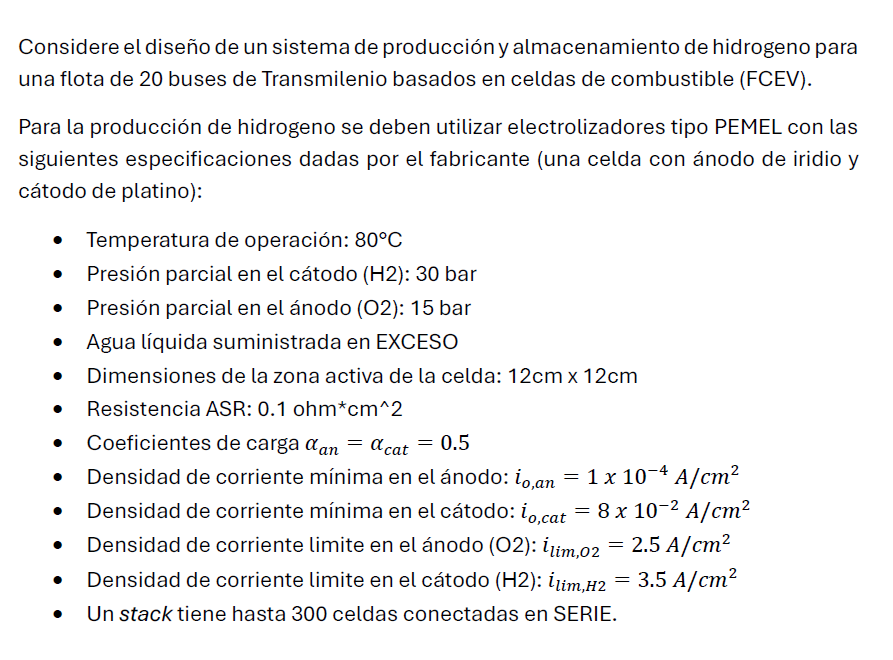

In [2]:
import numpy as np
import matplotlib.pyplot as plt 


In [ ]:
# Datos
n_b = 20 #numero de buses
T_op = 80 + 273.15 #K
P_cat = 30 #bar H2
P_an = 15 # bar O2

Dim_zon_act = 12 * 12 #cm2
R_ASR = 0.1 #ohm*cm2
alpha_an = 0.5
alpha_cat = 0.5
i_0_an = 1*10**-4 #A/cm2
i_0_cat = 8*10**-2 #A/cm2
i_lim_an = 2.5 #A/cm2
i_lim_cat = 3.5 #A/cm2

n_celdas = 300 # numero de celdas 

R_u = 8.31447 #J/mol*K
F = 96485.33 #C/mol



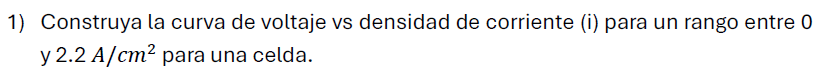

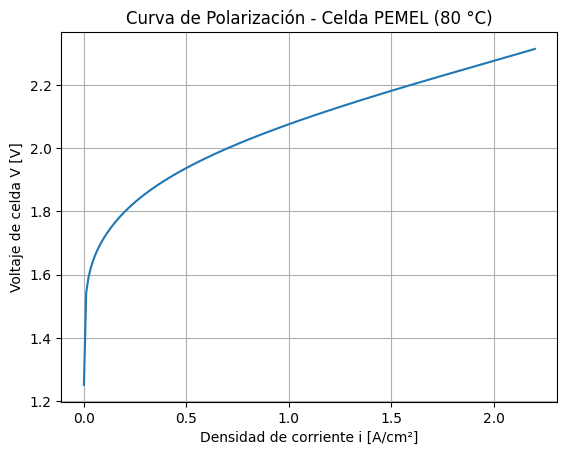

In [5]:
#Punto 1
#Voltaje de Nerst
E_N = 1.229 - 0.0009 * (T_op-298.15) + ((R_u*T_op)/(2*F)) * np.log(P_cat*(P_an**0.5))  #V
#Sobretensión de activación
def n_activación(i):
    n_act = ((R_u*T_op)/(alpha_an*F))*np.arcsinh(i/(2*i_0_an))  + ((R_u*T_op)/(alpha_cat*F))*np.arcsinh(i/(2*i_0_cat))
    return n_act
#Sobretensón de resisstencia
def n_resistencia(i):
    n_ohm = (i*R_ASR)
    return n_ohm
#Sobretensión de difusión
def n_difusión(i):
    n_diff = abs(((R_u*T_op)/(2*F)) * 0.5 * np.log(1-(i/i_lim_an))) + abs(((R_u*T_op)/(2*F)) * 1 * np.log(1-(i/i_lim_cat))) 
    return n_diff

# Grafica de Curva
i = np.linspace(0, 2.2, 200)
V = E_N + n_activación(i) + n_resistencia(i) + n_difusión(i)
   

plt.figure()
plt.plot(i, V)
plt.xlabel("Densidad de corriente i [A/cm²]")
plt.ylabel("Voltaje de celda V [V]")
plt.title("Curva de Polarización - Celda PEMEL (80 °C)")
plt.grid(True)
plt.show()

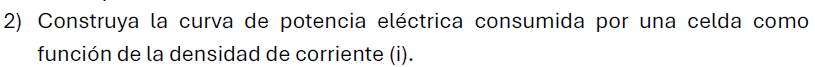

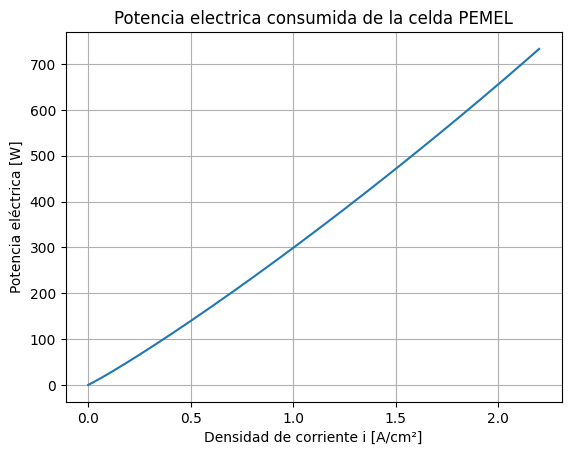

In [6]:
#Punto 2
#Potencia eléctrica
I = i*Dim_zon_act
P_elec = V*I

#Grafica de curva
plt.figure()
plt.plot(i, P_elec)
plt.xlabel('Densidad de corriente i [A/cm²]')
plt.ylabel('Potencia eléctrica [W]')
plt.title('Potencia electrica consumida de la celda PEMEL')
plt.grid(True)
plt.show()

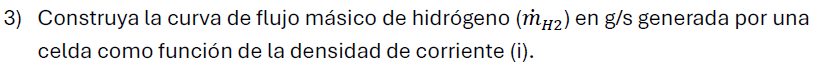

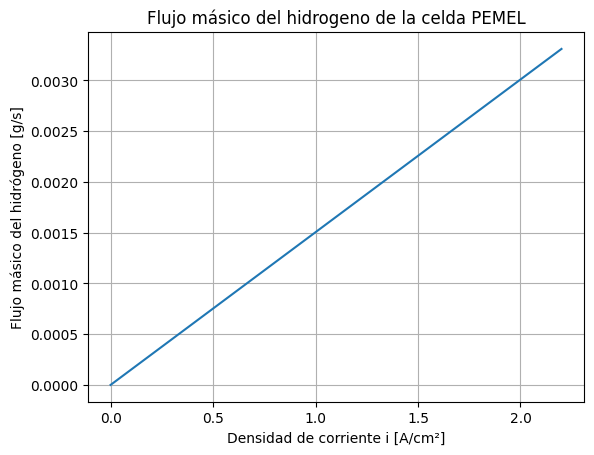

In [7]:
#Punto 3
#Flujo molar
n_H2 = (I)/(2*F)  #mol/s
#Flujo masico
MW_H2 = 2.016   #g/mol
m_H2 = n_H2*MW_H2

#Grafica de curva
plt.figure()
plt.plot(i, m_H2)
plt.xlabel('Densidad de corriente i [A/cm²]')
plt.ylabel('Flujo másico del hidrógeno [g/s]')
plt.title('Flujo másico del hidrogeno de la celda PEMEL')
plt.grid(True)
plt.show()

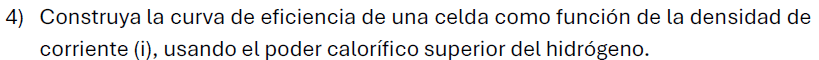

C:\Users\samel\AppData\Local\Temp\ipykernel_6236\1465206189.py:4: RuntimeWarning: invalid value encountered in divide
  eficiencia = (P_H2/P_elec)


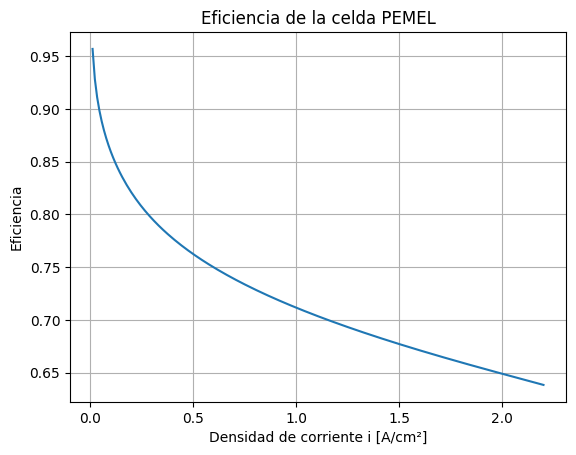

In [8]:
#Punto 4
HHV = 285000  #J/mol
P_H2 = (HHV*m_H2)/MW_H2
eficiencia = (P_H2/P_elec)

#Grafica de curva
plt.figure()
plt.plot(i, eficiencia)
plt.xlabel('Densidad de corriente i [A/cm²]')
plt.ylabel('Eficiencia')
plt.title('Eficiencia de la celda PEMEL')
plt.grid(True)
plt.show()

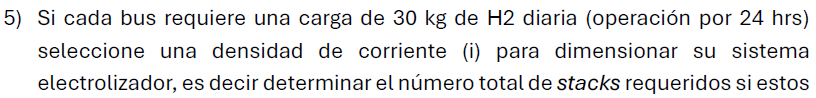
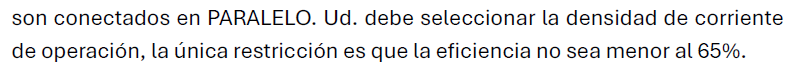

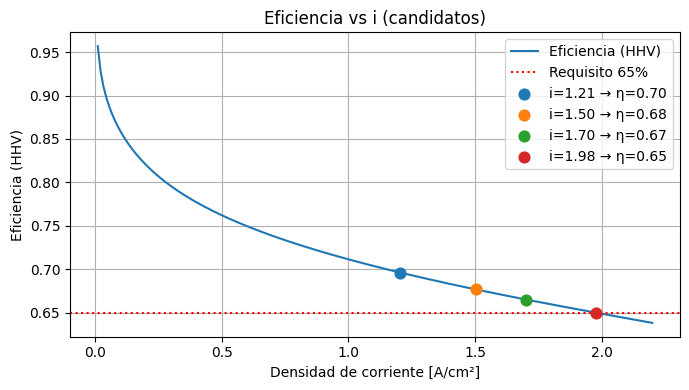

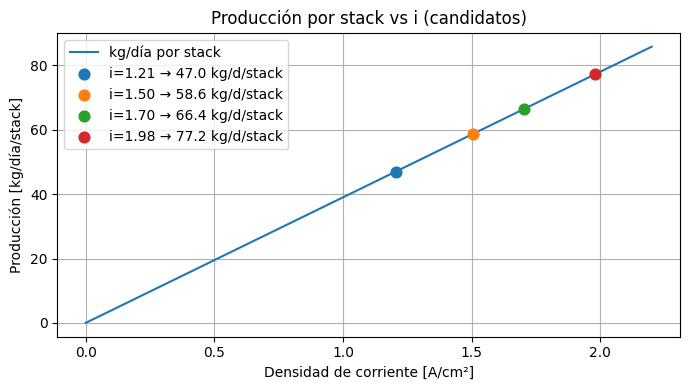

===== Comparación (sistema dimensionado en paralelo) =====
 i_sel  η(HHV)   E[V]    I[A]   V_stack[V]  kg/d/stack  stacks  kg/d total   P_stack[kW]  P_total[kW]  I_bus[A]  kWh/kg(sys)
 1.21   0.696   2.12    173.5       636.3         47.0      13       610.9        110.4       1435.4      2256         56.4
 1.50   0.677   2.18    216.5       654.6         58.6      11       644.9        141.7       1558.9      2382         58.0
 1.70   0.665   2.22    245.2       666.0         66.4      10       663.9        163.3       1632.9      2452         59.0
 1.98   0.650   2.27    285.0       681.6         77.2       8       617.3        194.2       1553.7      2280         60.4

===== Dimensionamiento FINAL con i = 1.50 A/cm² =====
i seleccionada            : 1.504 A/cm²
Eficiencia (HHV)          : 0.677
Voltaje por celda (E)     : 2.182 V
Corriente por celda (I)   : 216.5 A

-- Un stack (300 celdas en SERIE) --
Voltaje del stack         : 654.6 V
Potencia por celda        : 0.47 kW
Potencia 

In [10]:
# Producción por stack y comparación de candidatos (PARALELO)
# -------------------------
kg_dia_stack_curve = (m_H2 * n_celdas) * 86400.0 / 1000.0  # [kg/día] por stack
kg_dia_total = n_b * 30.0  # 20 buses * 30 kg/día = 600 kg/día
mask_ok = (eficiencia >= 0.65)
idx_ok = np.where(mask_ok)[0]
if idx_ok.size == 0:
    raise RuntimeError("No hay puntos con eficiencia >= 65% en el rango de i.")

# Densidades a evaluar 
i_candidatos = np.array([1.20, 1.50, 1.70, 2.00])  # A/cm2

res = []
for it in i_candidatos:
    # índice del i factible más cercano al candidato (η ≥ 65%)
    j = idx_ok[np.argmin(np.abs(i[idx_ok] - it))]

    # Magnitudes por celda/stack en ese punto
    i_sel_j        = float(i[j])
    eta_j          = float(eficiencia[j])
    E_celda_j      = float(V[j])
    I_celda_j      = float(I[j])
    kg_dia_stack_j = float(kg_dia_stack_curve[j])           # [kg/día] por stack
    P_stack_kW_j   = float((P_elec[j] * n_celdas) / 1000.0) # [kW] por stack
    V_stack_j      = float(E_celda_j * n_celdas)            # [V] por stack

    # Dimensionamiento en PARALELO para satisfacer la demanda total
    stacks_nec_j   = int(np.ceil(kg_dia_total / max(kg_dia_stack_j, 1e-12)))
    kg_d_total_j   = stacks_nec_j * kg_dia_stack_j          # [kg/día] total del sistema
    P_total_kW_j   = stacks_nec_j * P_stack_kW_j            # [kW] total del sistema
    I_bus_A_j      = stacks_nec_j * I_celda_j               # [A] bus DC (corriente suma en paralelo)
    kWh_kg_sys_j   = (P_total_kW_j * 24.0) / max(kg_d_total_j, 1e-12)

    res.append({
        "i_sel": i_sel_j,
        "eta": eta_j,
        "E_celda": E_celda_j,
        "I_celda": I_celda_j,
        "V_stack": V_stack_j,
        "kg_dia_stack": kg_dia_stack_j,
        "P_stack_kW": P_stack_kW_j,
        "stacks": stacks_nec_j,
        "kg_d_total": kg_d_total_j,
        "P_total_kW": P_total_kW_j,
        "I_bus_A": I_bus_A_j,
        "kWh_kg_sys": kWh_kg_sys_j,
    })

# Eficiencia con marcadores
plt.figure(figsize=(7,4))
plt.plot(i, eficiencia, label="Eficiencia (HHV)")
plt.axhline(0.65, color='r', ls=':', label='Requisito 65%')
for r in res:
    plt.scatter(r["i_sel"], r["eta"], s=60, zorder=3,
                label=f"i={r['i_sel']:.2f} → η={r['eta']:.2f}")
plt.xlabel("Densidad de corriente [A/cm²]"); plt.ylabel("Eficiencia (HHV)")
plt.title("Eficiencia vs i (candidatos)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# Producción por stack con marcadores
plt.figure(figsize=(7,4))
plt.plot(i, kg_dia_stack_curve, label="kg/día por stack")
for r in res:
    plt.scatter(r["i_sel"], r["kg_dia_stack"], s=60, zorder=3,
                label=f"i={r['i_sel']:.2f} → {r['kg_dia_stack']:.1f} kg/d/stack")
plt.xlabel("Densidad de corriente [A/cm²]"); plt.ylabel("Producción [kg/día/stack]")
plt.title("Producción por stack vs i (candidatos)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# ===== Tabla comparativa en PARALELO (sistema dimensionado) =====
print("===== Comparación (sistema dimensionado en paralelo) =====")
print(" i_sel  η(HHV)   E[V]    I[A]   V_stack[V]  kg/d/stack  stacks  kg/d total   P_stack[kW]  P_total[kW]  I_bus[A]  kWh/kg(sys)")
for r in res:
    print(f" {r['i_sel']:>4.2f}  {r['eta']:>6.3f}  {r['E_celda']:>5.2f}  {r['I_celda']:>7.1f}  "
          f"{r['V_stack']:>10.1f}  {r['kg_dia_stack']:>11.1f}  {r['stacks']:>6d}  "
          f"{r['kg_d_total']:>10.1f}  {r['P_stack_kW']:>11.1f}  {r['P_total_kW']:>11.1f}  "
          f"{r['I_bus_A']:>8.0f}  {r['kWh_kg_sys']:>11.1f}")

# -------------------------
# Dimensionamiento FINAL (i elegida = 1.50 A/cm²)
# Serie (stack) + Paralelo (sistema)
# -------------------------
i_target = 1.50
j = idx_ok[np.argmin(np.abs(i[idx_ok] - i_target))]  # punto factible más cercano (η≥65%)

# ---- Magnitudes por celda en el punto elegido ----
i_sel       = i[j]
E_sel       = V[j]
I_sel       = I[j]
P_celda_sel = P_elec[j]
eta_sel     = eficiencia[j]

# ---- SERIE: un stack de 300 celdas ----
kg_dia_stack = kg_dia_stack_curve[j]    # [kg/día] por stack
P_stack_W    = P_elec[j] * n_celdas     # [W] por stack
V_stack      = E_sel * n_celdas         # [V] del stack

# ---- PARALELO: sistema para cumplir demanda ----
stacks_necesarios = int(np.ceil(kg_dia_total / max(kg_dia_stack, 1e-12)))
kg_d_total = stacks_necesarios * kg_dia_stack                  # [kg/día]
P_total_W  = stacks_necesarios * P_stack_W                     # [W]
V_bus      = V_stack                                           # [V]
I_bus_A    = stacks_necesarios * I_sel                         # [A]
kWh_kg_final = (P_total_W * 24.0 / 1000.0) / max(kg_d_total, 1e-12)

print("\n===== Dimensionamiento FINAL con i = 1.50 A/cm² =====")
print(f"i seleccionada            : {i_sel:.3f} A/cm²")
print(f"Eficiencia (HHV)          : {eta_sel:.3f}")
print(f"Voltaje por celda (E)     : {E_sel:.3f} V")
print(f"Corriente por celda (I)   : {I_sel:.1f} A")

print("\n-- Un stack (300 celdas en SERIE) --")
print(f"Voltaje del stack         : {V_stack:.1f} V")
print(f"Potencia por celda        : {P_celda_sel/1000:.2f} kW")
print(f"Potencia por stack        : {P_stack_W/1000:.2f} kW")
print(f"Producción por stack      : {kg_dia_stack:.2f} kg/día")

print("\n-- Sistema (stacks en PARALELO) --")
print(f"Demanda total             : {kg_dia_total:.0f} kg/día")
print(f"Stacks requeridos (||)    : {stacks_necesarios} stacks")
print(f"Producción total          : {kg_d_total:.1f} kg/día")
print(f"Potencia total sistema    : {P_total_W/1e6:.3f} MW")
print(f"Bus DC (V x A)            : {V_bus:.0f} V × {I_bus_A:.0f} A")
print(f"Consumo eléctrico esp.    : {kWh_kg_final:.1f} kWh/kg  (≈39.4 kWh/kg teórico HHV como ref.)")

In [11]:
# --- Magnitudes eléctricas en i_sel ---
P_celda_sel = P_elec[idx_sel]           # [W] por celda
P_stack_W = P_celda_sel * n_celdas      # [W] por stack (300 celdas en serie)
V_stack = E_sel * n_celdas              # [V] del stack (útil para diseño DC)

# --- Demanda y número de stacks en paralelo ---
kg_dia_por_bus = 30.0
kg_dia_total = n_b * kg_dia_por_bus     # 20*30 = 600 kg/día

m_dot_stack_g_s = m_dot_g_s[idx_sel] * n_celdas         # [g/s] por stack
kg_dia_stack = m_dot_stack_g_s * 86400.0 / 1000.0       # [kg/día] por stack
stacks_necesarios = int(np.ceil(kg_dia_total / kg_dia_stack))

# --- Potencia total del sistema ---
P_total_W = P_stack_W * stacks_necesarios               # [W]

print("===== Potencia requerida =====")
print(f"i seleccionada           : {i_sel:.3f} A/cm²")
print(f"Eficiencia (HHV)         : {eficiencia1[idx_sel]:.3f}")
print(f"Voltaje por celda (E)    : {E_sel:.3f} V")
print(f"Corriente por celda (I)  : {I_sel:.2f} A")
print(f"Voltaje del stack        : {V_stack:.1f} V")
print(f"Potencia por celda       : {P_celda_sel/1000:.2f} kW")
print(f"Potencia por stack       : {P_stack_W/1000:.2f} kW")
print(f"Producción por stack     : {kg_dia_stack:.2f} kg/día")
print(f"Stacks requeridos (||)   : {stacks_necesarios}")
print(f"Potencia total sistema   : {P_total_W/1e6:.3f} MW")

NameError: name 'idx_sel' is not defined

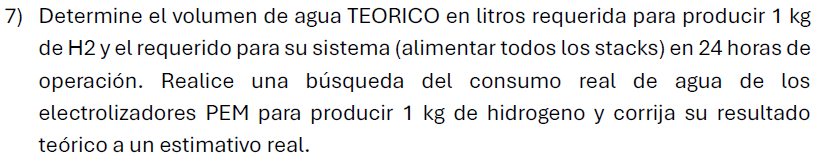

In [108]:
# --- Datos fisicoquímicos (mantengo tus nombres y estilo) ---
MW_H2   = 2.0159e-3      # kg/mol
MW_H2O  = 18.01528e-3    # kg/mol
rho_H2O = 0.997          # kg/L (~25 °C; si quieres, ajusta según T del agua de alimentación)

# --- Demanda diaria (ya definida en pasos previos, la recalculo aquí por claridad) ---
kg_dia_por_bus = 30.0
kg_dia_total   = n_b * kg_dia_por_bus     # 20 * 30 = 600 kg/día

# --- 1) Consumo TEÓRICO ---
kg_H2O_por_kgH2   = MW_H2O / MW_H2                      # ≈ 8.936 kg agua / kg H2
L_por_kgH2_teo    = kg_H2O_por_kgH2 / rho_H2O           # ≈ 8.96 L agua / kg H2
L_dia_total_teo   = L_por_kgH2_teo * kg_dia_total       # para la demanda de 600 kg/día

# Si ya calculaste stacks_necesarios y kg_dia_stack, usa la capacidad real del sistema
try:
    kg_dia_sistema = stacks_necesarios * kg_dia_stack   # [kg/día] por el dimensionamiento real
except NameError:
    kg_dia_sistema = kg_dia_total

L_dia_sistema_teo = L_por_kgH2_teo * kg_dia_sistema

# 2) Consumo REAL (estimado)
# (a) Agua de proceso (desionizada) típica reportada por NREL ≈ 2.939 gal/kg ≈ 11.1 L/kg
L_por_kgH2_real_proc = 11.1

# (b) Agua total (proceso + purificación/enfriamiento). Rango sugerido por RMI: 9 + (10 a 20) L/kg
L_por_kgH2_real_total_min = 19.0   # L/kg
L_por_kgH2_real_total_max = 29.0   # L/kg
L_por_kgH2_real_total_mid = 24.0   # valor medio para estimado puntual

# Totales diarios para la demanda objetivo (600 kg/d) y para el sistema dimensionado
L_dia_total_real_proc    = L_por_kgH2_real_proc    * kg_dia_total
L_dia_total_real_totalLo = L_por_kgH2_real_total_min * kg_dia_total
L_dia_total_real_totalHi = L_por_kgH2_real_total_max * kg_dia_total
L_dia_total_real_totalMd = L_por_kgH2_real_total_mid * kg_dia_total

L_dia_sist_real_proc     = L_por_kgH2_real_proc    * kg_dia_sistema
L_dia_sist_real_totalLo  = L_por_kgH2_real_total_min * kg_dia_sistema
L_dia_sist_real_totalHi  = L_por_kgH2_real_total_max * kg_dia_sistema
L_dia_sist_real_totalMd  = L_por_kgH2_real_total_mid * kg_dia_sistema

# --- Reporte ---
print("===== Consumo de agua para electrólisis (por estequiometría y estimación real) =====")
print(f"Teórico por 1 kg H2         : {L_por_kgH2_teo:.2f} L/kg")
print(f"Teórico demanda 600 kg/d    : {L_dia_total_teo:,.0f} L/día")
print(f"Teórico sistema dimensionado: {L_dia_sistema_teo:,.0f} L/día")

print("\n-- Estimación REAL (a) Agua de proceso --")
print(f"Real (proceso) por 1 kg H2  : {L_por_kgH2_real_proc:.1f} L/kg")
print(f"Real (proceso) 600 kg/d     : {L_dia_total_real_proc:,.0f} L/día")
print(f"Real (proceso) sistema      : {L_dia_sist_real_proc:,.0f} L/día")

print("\n-- Estimación REAL (b) Agua total (proceso+purif.+enfriamiento) --")
print(f"Real (total) por 1 kg H2    : {L_por_kgH2_real_total_min:.0f}–{L_por_kgH2_real_total_max:.0f} L/kg (usar ~{L_por_kgH2_real_total_mid:.0f} L/kg como punto medio)")
print(f"Real (total) 600 kg/d       : {L_dia_total_real_totalLo:,.0f} – {L_dia_total_real_totalHi:,.0f} L/día (≈ {L_dia_total_real_totalMd:,.0f} L/día medio)")
print(f"Real (total) sistema        : {L_dia_sist_real_totalLo:,.0f} – {L_dia_sist_real_totalHi:,.0f} L/día (≈ {L_dia_sist_real_totalMd:,.0f} L/día medio)")

===== Consumo de agua para electrólisis (por estequiometría y estimación real) =====
Teórico por 1 kg H2         : 8.96 L/kg
Teórico demanda 600 kg/d    : 5,378 L/día
Teórico sistema dimensionado: 5,597 L/día

-- Estimación REAL (a) Agua de proceso --
Real (proceso) por 1 kg H2  : 11.1 L/kg
Real (proceso) 600 kg/d     : 6,660 L/día
Real (proceso) sistema      : 6,931 L/día

-- Estimación REAL (b) Agua total (proceso+purif.+enfriamiento) --
Real (total) por 1 kg H2    : 19–29 L/kg (usar ~24 L/kg como punto medio)
Real (total) 600 kg/d       : 11,400 – 17,400 L/día (≈ 14,400 L/día medio)
Real (total) sistema        : 11,863 – 18,107 L/día (≈ 14,985 L/día medio)


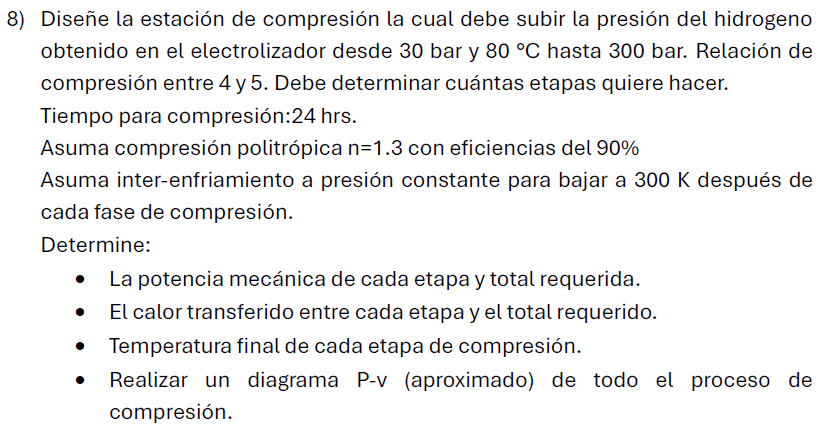